# **Anomaly Detection con fattorizzazione SVD**

Questo Notebook mostra come utilizzare la ***Singular Value Decomposition*** (SVD) per la risoluzione di un problema di anomaly detection su immagini industriali.

## **Fase 1:** Caricamento del dataset

In [90]:
from utils.image import FSRandomImageGenerator
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
from utils.plot import ROC

In [91]:
target_shape = (150, 150, 1)

# Training set
train_data_path = "./mvtec_bottle_dataset/train/good/*.*"
train_generator = FSRandomImageGenerator(data_path=train_data_path, image_shape=target_shape, shuffle=False)
train_set = train_generator.get_all()
print("Training set size:", len(train_set))

# Test set
test_data_path = "./mvtec_bottle_dataset/test/good/*.*"
test_generator = FSRandomImageGenerator(data_path=test_data_path, image_shape=target_shape)
test_set = test_generator.get_all()
print("Test set size:", len(test_set))

# Anomaly set
broken_data_path = "./mvtec_bottle_dataset/anomalies/broken/*.*"
broken_large_data_path = "./mvtec_bottle_dataset/anomalies/broken_large/*.*"
contamination_data_path = "./mvtec_bottle_dataset/anomalies/contamination/*.*"
anomalies_generator = FSRandomImageGenerator([broken_data_path, broken_large_data_path, contamination_data_path], image_shape=target_shape)
anom_set = anomalies_generator.get_all()
print("Anomaly set size:", len(anom_set))

Training set size: 209
Test set size: 20
Anomaly set size: 63


Esempio di immagini *normali* (bottiglie sane):

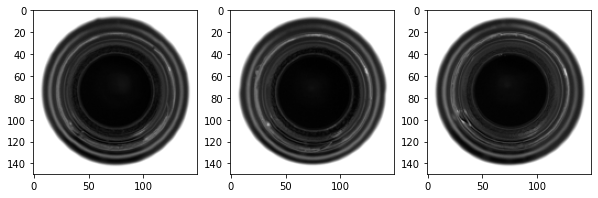

In [92]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(train_set[i].reshape(target_shape[:2]), cmap="gray")

Esempio di immagini *anomale* (bottiglie difettose):

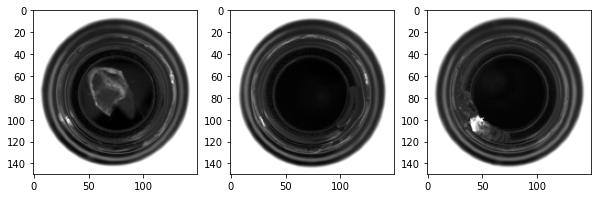

In [93]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(anom_set[i].reshape(target_shape[:2]), cmap="gray")

### **1.1:** Manipolazione del dataset di training

Composizione della matrice dei dati **X**.

In [94]:
# numero di righe della matrice
n_rows = target_shape[0] * target_shape[1]
# numero di colonne della matrice
n_cols = len(train_set)

X = np.zeros(shape = (n_rows, n_cols))

for i, img in enumerate(train_set):
    # ogni colonna di X contiene una immagine del dataset di training
    X[:, i] = img.reshape(n_rows)

print(X.shape)

(22500, 209)


## **Fase 2:** Fattorizzazione SVD 

In [96]:
U, S, V_t = svd(X, full_matrices=False)

print("U :", U.shape)
print("S :", S.shape)
print("V :", V_t.shape)

U : (22500, 209)
S : (209,)
V : (209, 209)


Plot dei **valori singolari**

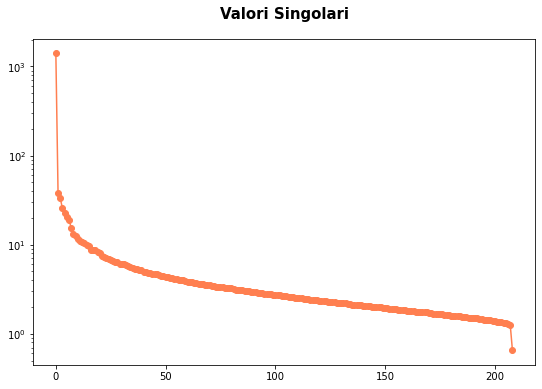

In [97]:
plt.figure(figsize = (9, 6))
plt.plot(S, color='coral', marker='o')
plt.title("Valori Singolari",fontsize=15, weight="bold", pad=20)
plt.yscale("log")
plt.show()

Plot delle colonne di U ( **vettori singolari sinistri** )

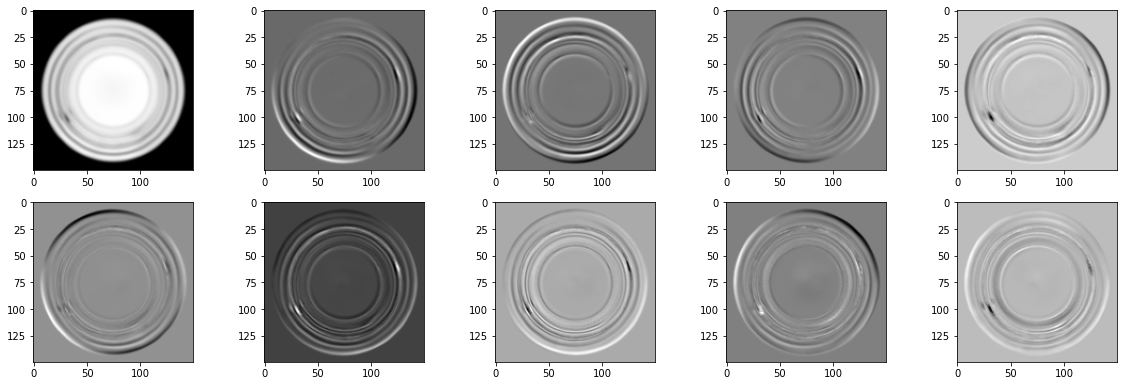

In [98]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(10):
   plt.subplot(10/ columns + 1, columns, i + 1)
   plt.imshow(U[:,i].reshape(target_shape[0], target_shape[1]), cmap='gray')

Test di ricostruzione con 10 vettori singolari

In [99]:
U_k = U[:,:10]

In [100]:
# immagine di esempio
test_img = test_set[0]
test_img = test_img.reshape((n_rows, 1))
test_img.shape

(22500, 1)

In [101]:
# Calcolo del vettore dei coefficenti
c = np.dot(U_k.T, test_img)
# Calcolo dell'immagine ricostruita
rec = np.dot(U_k, c)

residual = np.linalg.norm(test_img - rec, ord = 2) ** 2

print("Residual:", residual)
print("Coefficient shape:", c.shape)
print("Recostruction shape:", rec.shape)

Residual: 18.672840603892112
Coefficient shape: (10, 1)
Recostruction shape: (22500, 1)


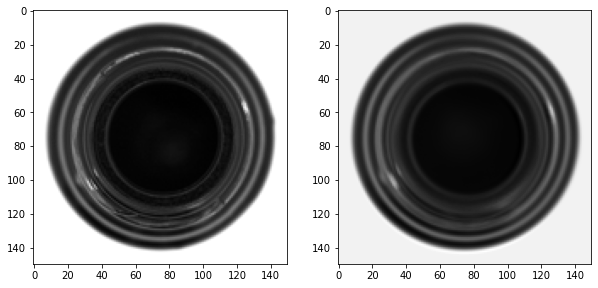

In [102]:
# Visualizzazione
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(test_img.reshape(target_shape[0], target_shape[1]), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(rec.reshape(target_shape[0], target_shape[1]), cmap="gray")

Test su immagine anomala

Residual: 95.10499427290503


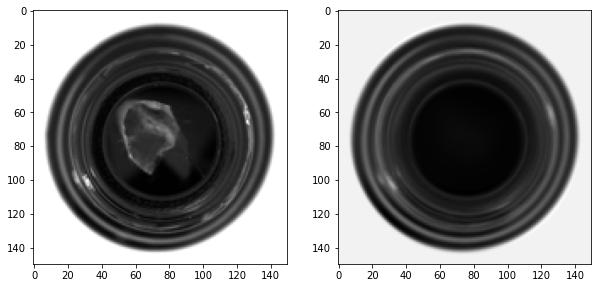

In [103]:
plt.figure(figsize=(10,10))

anom_img = anom_set[0]
anom_img = anom_img.reshape((n_rows, 1))

# Calcolo del vettore dei coefficenti
c = np.dot(U_k.T, anom_img)
# Calcolo dell'immagine ricostruita
rec = np.dot(U_k, c)

residual = np.linalg.norm(anom_img - rec, ord = 2) ** 2

print("Residual:", residual)

plt.subplot(1, 2, 1)
plt.imshow(anom_img.reshape(target_shape[0], target_shape[1]), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(rec.reshape(target_shape[0], target_shape[1]), cmap="gray")

## **Fase 3:** Valutazione del modello

Calcolo degli errori di ricostruzione sulle immagini di test

In [104]:
test_errors = []
for test_img in test_set:
    test_img = test_img.reshape(n_rows, 1)
    c = np.dot(U_k.T, test_img)
    rec = np.dot(U_k, c)

    test_errors.append(np.linalg.norm(test_img - rec, ord = 2) ** 2)

min_test_err = min(test_errors)
max_test_err = max(test_errors)

print("min. error =", min_test_err)
print("max. error =", max_test_err)

min. error = 12.820885439755049
max. error = 28.370312700636195


Calcolo degli errori di ricostruzione sulle anomalie

In [105]:
anom_errors = []
for anom_img in anom_set:
    anom_img = anom_img.reshape(n_rows, 1)
    c = np.dot(U_k.T, anom_img)
    rec = np.dot(U_k, c)

    anom_errors.append(np.linalg.norm(anom_img - rec, ord = 2) ** 2)

min_anom_err = min(anom_errors)
max_anom_err = max(anom_errors)

print("min. error =", min_anom_err)
print("max. error =", max_anom_err)

min. error = 14.715794544905842
max. error = 199.71414980972787


Plot della ROC

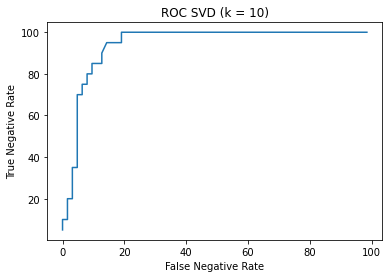

AUC = 92.65873015873012
Top left point = (14.285714285714285, 95.0)
Top left threshold = 26.814149809735056


In [106]:
plt.title("ROC SVD (k = 10)")
roc = ROC(test_errors, anom_errors, max(max_test_err, max_anom_err) , min(min_test_err, min_anom_err), 0.1)
roc.plot(draw_th=False, line_type="-")

print("AUC =", roc.AUC())
top_left_point, top_left_th = roc.top_left()
print("Top left point =", top_left_point)
print("Top left threshold =", top_left_th)

Test con 100 vettori singolari

min. = 4.916604724848413
max. = 13.383176756359484
min. = 7.641424073856102
max. = 138.43013861357787


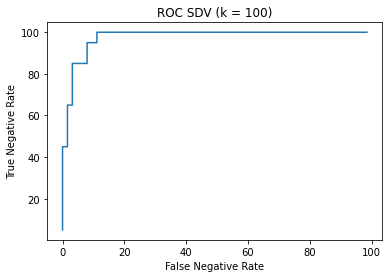

AUC = 96.11111111111107
Top left point = (7.936507936507936, 95.0)
Top left threshold = 13.030138613581425


In [107]:
k = 100
U_k = U[:, :k]

test_errors = []
for test_img in test_set:
    test_img = test_img.reshape(n_rows, 1)
    c = np.dot(U_k.T, test_img)
    rec = np.dot(U_k, c)

    test_errors.append(np.linalg.norm(test_img - rec, ord = 2) ** 2)

min_test_err = min(test_errors)
max_test_err = max(test_errors)

print("min. =", min_test_err)
print("max. =", max_test_err)

anom_errors = []
for anom_img in anom_set:
    anom_img = anom_img.reshape(n_rows, 1)
    c = np.dot(U_k.T, anom_img)
    rec = np.dot(U_k, c)

    anom_errors.append(np.linalg.norm(anom_img - rec, ord = 2) ** 2)

min_anom_err = min(anom_errors)
max_anom_err = max(anom_errors)

print("min. =", min_anom_err)
print("max. =", max_anom_err)

plt.title("ROC SDV (k = 100)")
roc = ROC(test_errors, anom_errors, max(max_test_err, max_anom_err), min(min_test_err, min_anom_err), 0.1)
roc.plot(draw_th=False, line_type="-")

print("AUC =", roc.AUC())
top_left_point, top_left_th = roc.top_left()
print("Top left point =", top_left_point)
print("Top left threshold =", top_left_th)